# Interactive Visualizion with Open Altimetry & Google Earth Engine

By Philipp Arndt \
Scripps Institution of Oceanography, University of California San Diego \
Github: [@fliphilipp](https://github.com/fliphilipp) \
Contact: parndt@ucsd.edu

Copied and modified by Ben Purinton, 9 AUG 2023

In [80]:
%matplotlib widget 
import os
import ee
import geemap
import requests
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta
from ipywidgets import Layout
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import warp
import json

    
The import below is a class that I wrote myself. It helps us read and store data from the OpenAltimetry API.  
If you are interested in how this works, you can find the code in `utils/oa.py`.

In [81]:
import sys
sys.path.append('/home/jovyan/surfit/shared_code')
print(sys.path)

from utils.oa import dataCollector

['/home/jovyan/surfit/contributors/ben', '/srv/conda/envs/notebook/share/qgis/python/plugins', '/srv/conda/envs/notebook/share/qgis/python', '/home/jovyan/surfit/contributors/ben', '/srv/conda/envs/notebook/lib/python310.zip', '/srv/conda/envs/notebook/lib/python3.10', '/srv/conda/envs/notebook/lib/python3.10/lib-dynload', '', '/srv/conda/envs/notebook/lib/python3.10/site-packages', '/home/jovyan/surfit/shared_code', '/home/jovyan/surfit/shared_code', '/home/jovyan/surfit/shared_code']


In [82]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

## Get data dictionary

In [83]:
# Load JSON data from a file into a Python dictionary
with open('/home/jovyan/surfit/data/icesat2_tracks.json') as json_file:
    data_dict = json.load(json_file)

data_dict

{'utqiagvik': {'granule_id': 'ATL03_20220417011336_03811505_006_02.h5',
  'beam': 'gt1l',
  'viz_url': 'http://openaltimetry.org/data/api/icesat2/atl03?date=2022-04-17&minx=-156.83823035497537&miny=71.24790555527827&maxx=-156.36503098588742&maxy=71.46395004246523&trackId=381&outputFormat=json'},
 'blackrock': {'granule_id': 'ATL03_20200708170622_02040802_006_01.h5',
  'beam': 'gt1l',
  'viz_url': 'http://openaltimetry.org/data/api/icesat2/atl03?date=2020-07-08&minx=-119.31823117419968&miny=40.61614913888411&maxx=-119.17751566966596&maxy=40.85301044291694&trackId=204&outputFormat=json'}}

## General Viz

In [84]:
list_of_sites = list(data_dict.keys())
list_of_sites

['utqiagvik', 'blackrock']

Parameters available for `dataCollector.visualize_sentinel2()`:

```
- max_cloud_prob = 20
- days_buffer = 10
- gamma_value = 1.8
- title = 'ICESat-2 data'
- imagery_filename = 'my-satellite-image.tif'
- plot_filename = 'my-plot.jpg'
```

--> Getting data from OpenAltimetry.
---> requesting ATL03 data... 50283 data points.
---> requesting ATL06 data... 1215 data points.
---> requesting ATL07 data... 1171 data points.
---> requesting ATL08 data... 243 data points.
---> requesting ATL10 data... No data.
---> requesting ATL12 data... 7 data points.
---> requesting ATL13 data... 1109 data points.
The ground track is 24.2 km long.
Looking for Sentinel-2 images from 2022-04-07T12:00:00 to 2022-04-27T12:00:00 --> there are 9 cloud-free images.
--> Closest cloud-free Sentinel-2 image to ICESat:
    - product_id: S2A_MSIL2A_20220417T222541_N0400_R015_T04WEE_20220418T013027
    - time difference: Same day as ICESat-2
    - mean along-track cloud probability: 1.0
--> Downloaded the 8-bit RGB image as ignore_rgb_output.tif.
--> Saved plot as utqiagvik_open_altimetry_sentinel_plot.png.
--> Getting data from OpenAltimetry.
---> requesting ATL03 data... 51426 data points.
---> requesting ATL06 data... No data.
---> requesting ATL07 da

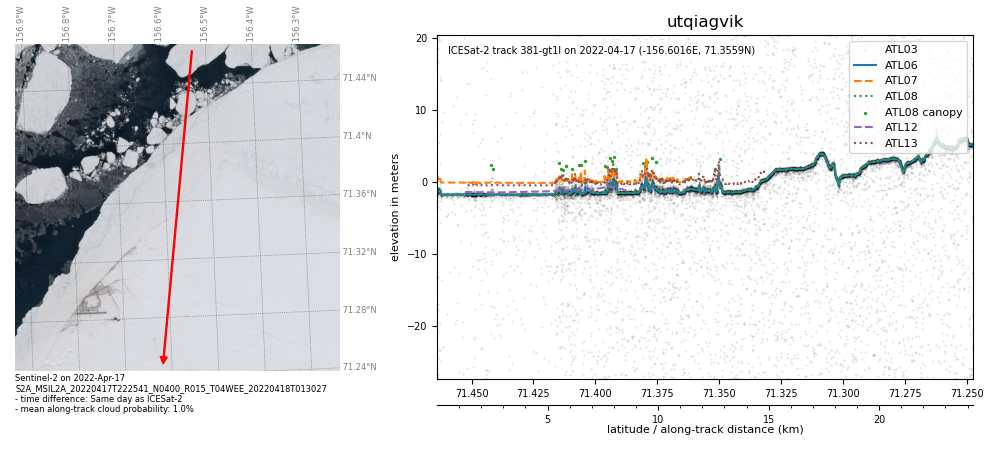

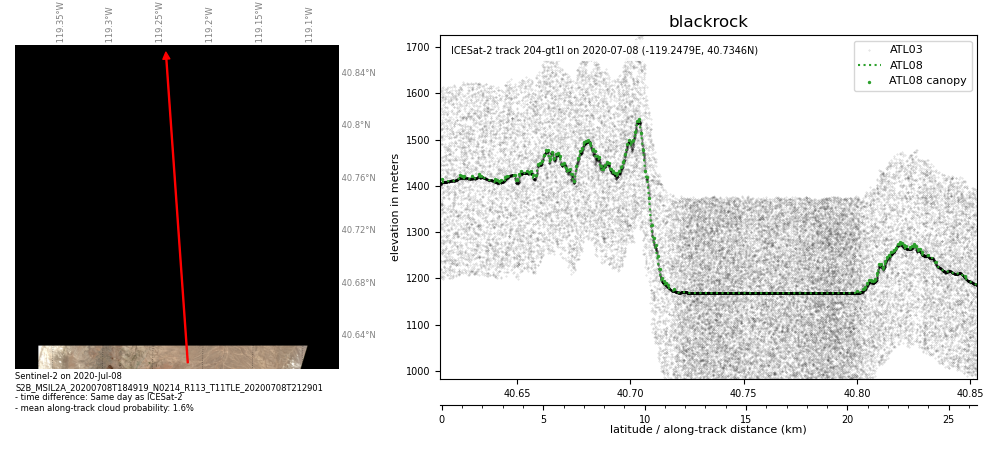

In [96]:
for site in list_of_sites:
    url = data_dict[site]['viz_url']
    beam = data_dict[site]['beam']
    
    is2data = dataCollector(oaurl=url, beam=beam)
    fig = is2data.visualize_sentinel2(max_cloud_prob=10, 
                                      plot_filename=f"{site}_open_altimetry_sentinel_plot.png", 
                                      #imagery_filename=f"{site}_sentinel2_rgb.tif",
                                      imagery_filename='ignore_rgb_output.tif',
                                      title=site,
                                      days_buffer=10)

## ATL03/06 plots

Start by setting the `site` variable below to study area you want to look at:

In [86]:
site = 'blackrock' # utqiagvik or blackrock

### Query the data

In [87]:
url = data_dict[site]['viz_url']
beam = data_dict[site]['beam']
    
is2data = dataCollector(oaurl=url, beam=beam, verbose=True)

OpenAltimetry API URL: http://openaltimetry.org/data/api/icesat2/atlXX?date=2020-07-08&minx=-119.31823117419968&miny=40.61614913888411&maxx=-119.17751566966596&maxy=40.85301044291694&trackId=204&outputFormat=json&beamName=gt1l&client=jupyter
Date: 2020-07-08
Track: 204
Beam: gt1l
Latitude limits: [40.61614913888411, 40.85301044291694]
Longitude limits: [-119.31823117419968, -119.17751566966596]


### Request the data from the OpenAltimetry API

Here we usethe `requestData()` function of the `dataCollector` class, which is defined in `utils/oa.py`. It downloads all data products that are available on OpenAltimetry based on the inputs with which we initialized our `dataCollector`, and writes them to pandas dataframes.

In [88]:
is2data.requestData(verbose=True)

---> requesting ATL03 data... 51426 data points.
---> requesting ATL06 data... No data.
---> requesting ATL07 data... No data.
---> requesting ATL08 data... 264 data points.
---> requesting ATL10 data... No data.
---> requesting ATL12 data... No data.
---> requesting ATL13 data... No data.


### Plot

In [ ]:
def dist_latlon2meters(lat1, lon1, lat2, lon2):
    # returns the distance between two coordinate points - (lon1, lat1) and (lon2, lat2) along the earth's surface in meters.
    R = 6371000
    def deg2rad(deg):
        return deg * (np.pi/180)
    dlat = deg2rad(lat2-lat1)
    dlon = deg2rad(lon2-lon1)
    a = np.sin(dlat/2) * np.sin(dlat/2) + np.cos(deg2rad(lat1)) * np.cos(deg2rad(lat2)) * np.sin(dlon/2) * np.sin(dlon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

lat1, lat2 = is2data.atl08.lat[0], is2data.atl08.lat.iloc[-1]
lon1, lon2 = is2data.atl08.lon[0], is2data.atl08.lon.iloc[-1]

ground_track_length = dist_latlon2meters(lat1, lon1, lat2, lon2)
print('The ground track is about %.1f kilometers long.' % (ground_track_length/1e3))

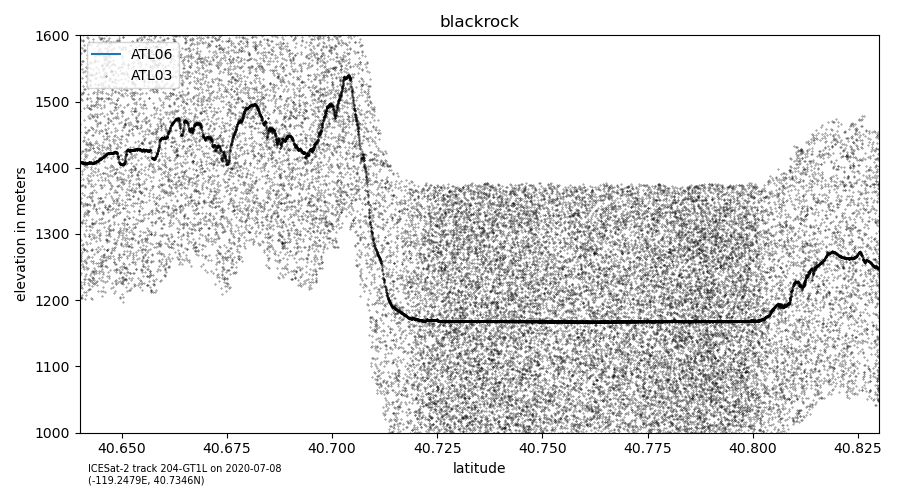

In [89]:
# create the figure and axis
fig, ax = plt.subplots(figsize=[9,5])

# plot the data products
atl06 = ax.plot(is2data.atl06.lat, is2data.atl06.h, c='C0', linestyle='-', label='ATL06')
atl03 = ax.scatter(is2data.atl03.lat, is2data.atl03.h, s=0.1, color='black', label='ATL03', zorder=-1, alpha=0.7)

# add labels, title and legend
ax.set_xlabel('latitude')
ax.set_ylabel('elevation in meters')
ax.set_title(f'{site}')
ax.legend(loc='upper left')

# add some text to provide info on what is plotted
info = 'ICESat-2 track {track:d}-{beam:s} on {date:s}\n({lon:.4f}E, {lat:.4f}N)'.format(track=is2data.track, 
                                                                                        beam=is2data.beam.upper(), 
                                                                                        date=is2data.date, 
                                                                                        lon=np.mean(is2data.lonlims), 
                                                                                        lat=np.mean(is2data.latlims))
infotext = ax.text(0.01, -0.08, info,
                   horizontalalignment='left', 
                   verticalalignment='top', 
                   transform=ax.transAxes,
                   fontsize=7,
                   bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))

# set the axis limits
if site == 'utqiagvik':
    ax.set_xlim(71.35, 71.45)
    ax.set_ylim(-5, 5)
    
if site == 'blackrock':
    ax.set_xlim(40.64, 40.83)
    ax.set_ylim(1000, 1600)

fig.tight_layout()

fig.savefig(f'{site}_profile_plot_atl03_06.jpg', dpi=300)

### Zoom plot

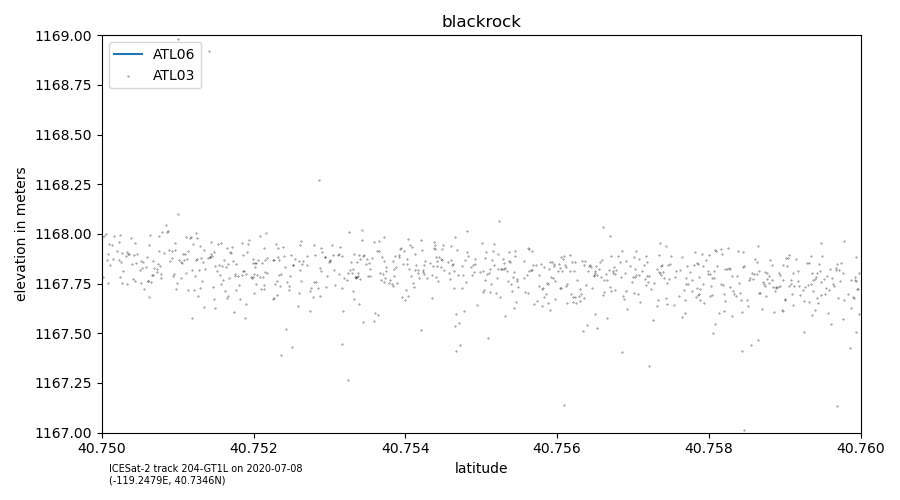

In [92]:
# create the figure and axis
fig, ax = plt.subplots(figsize=[9,5])

# plot the data products
atl06 = ax.plot(is2data.atl06.lat, is2data.atl06.h, c='C0', linestyle='-', label='ATL06')
atl03 = ax.scatter(is2data.atl03.lat, is2data.atl03.h, s=0.1, color='black', label='ATL03', zorder=-1, alpha=0.7)

# add labels, title and legend
ax.set_xlabel('latitude')
ax.set_ylabel('elevation in meters')
ax.set_title(f'{site}')
ax.legend(loc='upper left')

# add some text to provide info on what is plotted
info = 'ICESat-2 track {track:d}-{beam:s} on {date:s}\n({lon:.4f}E, {lat:.4f}N)'.format(track=is2data.track, 
                                                                                        beam=is2data.beam.upper(), 
                                                                                        date=is2data.date, 
                                                                                        lon=np.mean(is2data.lonlims), 
                                                                                        lat=np.mean(is2data.latlims))
infotext = ax.text(0.01, -0.08, info,
                   horizontalalignment='left', 
                   verticalalignment='top', 
                   transform=ax.transAxes,
                   fontsize=7,
                   bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))

# set the axis limits
if site == 'utqiagvik':
    ax.set_xlim(71.31, 71.33)
    ax.set_ylim(1, 3)
    
if site == 'blackrock':
    ax.set_xlim(40.75, 40.76)
    ax.set_ylim(1167, 1169)

fig.tight_layout()

fig.savefig(f'{site}_profile_plot_atl03_06_zoom.jpg', dpi=300)

### All data plot

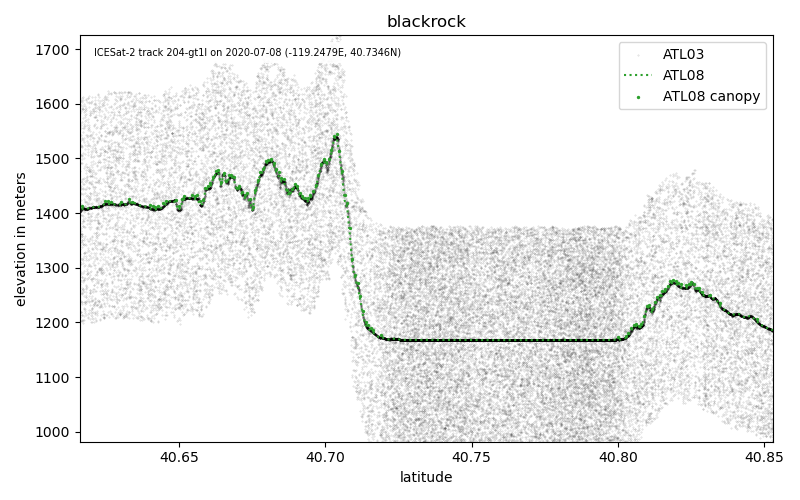

In [93]:
fig = is2data.plotData(title=site);
fig

fig.savefig(f'{site}_profile_plot_all_products.jpg', dpi=300)

## Interactive GMap

In [115]:
from ipywidgets import Layout

In [119]:
site = 'blackrock' # utqiagvik or blackrock

In [120]:
url = data_dict[site]['viz_url']
beam = data_dict[site]['beam']
    
is2data = dataCollector(oaurl=url, beam=beam, verbose=False)

is2data.requestData(verbose=False)

lat1, lat2 = is2data.atl08.lat[0], is2data.atl08.lat.iloc[-1]
lon1, lon2 = is2data.atl08.lon[0], is2data.atl08.lon.iloc[-1]

In [121]:
Map = geemap.Map(layout=Layout(width='70%', max_height='450px'))
ground_track_coordinates = list(zip(is2data.atl08.lon, is2data.atl08.lat))
ground_track_projection = 'EPSG:4326' # <-- this specifies that our data longitude/latitude in degrees [https://epsg.io/4326]
gtx_feature = ee.FeatureCollection(ee.Geometry.LineString(coords=ground_track_coordinates, 
                                      proj=ground_track_projection, 
                                      geodesic=True))
Map.addLayer(gtx_feature, {'color': 'red'}, 'ground track')
center_lon = (lon1 + lon2) / 2
center_lat = (lat1 + lat2) / 2
Map.add_basemap('SATELLITE') # <-- this adds a layer called 'Google Satellite'
Map.layer_opacity(name='Google Satellite', opacity=0.5)
Map.addLayer(gtx_feature,{'color': 'red'},'ground track')
Map.setCenter(center_lon, center_lat, zoom=10);

Map

Map(center=[40.73486328125, -119.229736328125], controls=(WidgetControl(options=['position', 'transparent_bg']…